## Importando bibliotecas necessárias


In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dot, Flatten, Dense, Dropout, Concatenate, Lambda, BatchNormalization
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

## Importando dataset

In [37]:
ratings_df = pd.read_csv('books/Ratings.csv')
books_df = pd.read_csv('books/Books.csv')

/var/folders/cn/069x0qks6_x1z9xwgl6_057r0000gn/T/ipykernel_13496/194626346.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('books/Books.csv')


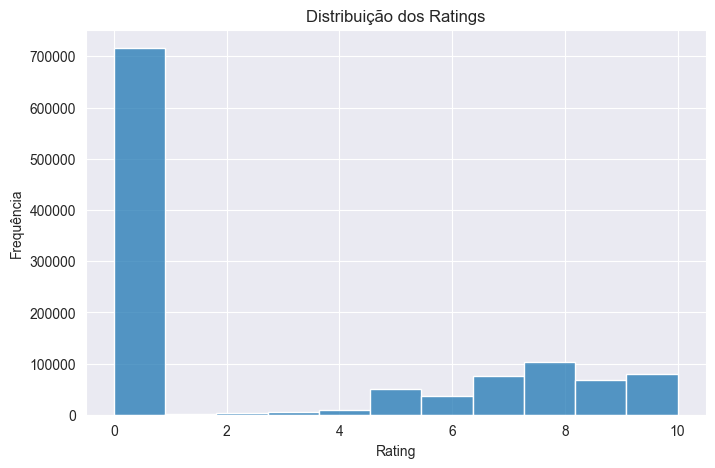

In [38]:
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df["Book-Rating"], bins=11, kde=False)  # Ratings vão de 0 a 10
plt.title("Distribuição dos Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [39]:
ratings_df = ratings_df[ratings_df["Book-Rating"] > 0]

## Codificar os IDs para índices inteiros contínuos

In [40]:
books_df = books_df[["ISBN", "Book-Author"]].dropna()
books_df["Book-Author"] = books_df["Book-Author"].str.strip().str.lower()

author2id = {author: idx for idx, author in enumerate(books_df["Book-Author"].unique())}
books_df["author_id"] = books_df["Book-Author"].map(author2id)
isbn_to_author_id = dict(zip(books_df["ISBN"], books_df["author_id"]))

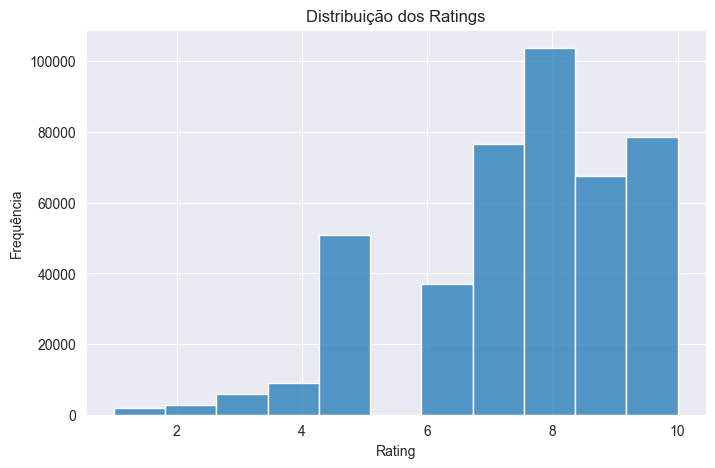

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df["Book-Rating"], bins=11, kde=False)  # Ratings vão de 0 a 10
plt.title("Distribuição dos Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [42]:
ratings_df["Book-Author"] = ratings_df["ISBN"].map(isbn_to_author_id)

ratings_df = ratings_df.dropna(subset=["Book-Author"])
ratings_df["Book-Author"] = ratings_df["Book-Author"].astype(int)

In [43]:
scaler = StandardScaler()
ratings_df["Book-Rating"] = scaler.fit_transform(ratings_df[["Book-Rating"]])


print(f"Média (do scaler): {scaler.mean_[0]:.2f}")
print(f"Desvio padrão (do scaler): {scaler.scale_[0]:.2f}")

In [44]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()
author_encoder = LabelEncoder()

ratings_df["User-ID"] = user_encoder.fit_transform(ratings_df["User-ID"])
ratings_df["ISBN"] = book_encoder.fit_transform(ratings_df["ISBN"])
ratings_df["Book-Author"] = author_encoder.fit_transform(ratings_df["Book-Author"])

num_users = ratings_df["User-ID"].nunique()
num_books = ratings_df["ISBN"].nunique()
num_authors = ratings_df["Book-Author"].nunique()

train_df, val_df = train_test_split(ratings_df, test_size=0.4, random_state=42)

## Avaliando a esparcidade do dataset

In [45]:
def compute_sparsity(df, user_col="User-ID", item_col="ISBN"):
    num_users = df[user_col].nunique()
    num_items = df[item_col].nunique()
    num_interactions = len(df)

    total_possible = num_users * num_items
    sparsity = 1 - (num_interactions / total_possible)

    print(f"Número de usuários: {num_users}")
    print(f"Número de itens: {num_items}")
    print(f"Número de interações: {num_interactions}")
    print(f"Total possível de interações: {total_possible}")
    print(f"Esparsidade: {sparsity:.4f} ({sparsity*100:.2f}%)")

    return sparsity

In [46]:
compute_sparsity(train_df)

Número de usuários: 50696
Número de itens: 105983
Número de interações: 230304
Total possível de interações: 5372914168
Esparsidade: 1.0000 (100.00%)


0.9999571361103493

## Criando o modelo de embeddings

In [47]:
embedding_dim = 4

# Inputs
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))
author_input = Input(shape=(1,))

# Embeddings
user_embedding = Embedding(num_users, embedding_dim, name="user_embedding", embeddings_regularizer=l2(1e-6))(user_input)
book_embedding = Embedding(num_books, embedding_dim, name="book_embedding", embeddings_regularizer=l2(1e-6))(book_input)
author_embedding = Embedding(num_authors, embedding_dim, name="author_embedding", embeddings_regularizer=l2(1e-6))(author_input)

# Flatten
user_vec = Flatten()(user_embedding)
book_vec = Flatten()(book_embedding)
author_vec = Flatten()(author_embedding)

# Combinação dos vetores
x = Concatenate()([user_vec, book_vec, author_vec])

x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)


outputs = Dense(1)(x)

# Modelo
model = Model(inputs=[user_input, book_input, author_input], outputs=outputs)
# model.compile(optimizer="adam", loss=Huber(), metrics=["mae"])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 1)      │     68,091 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_embedding      │ (None, 1, 1)      │    149,834 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_embedding    │ (None, 1, 1)      │     60,342 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1)         │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 1)         │          0 │ book_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 1)         │          0 │ author_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3)         │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │          4 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 278,271 (1.06 MB)

 Trainable params: 278,271 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Treinando a rede

In [49]:
history = model.fit(
    [train_df["User-ID"].values, train_df["ISBN"].values, train_df["Book-Author"].values],
    train_df["Book-Rating"].values,
    epochs=50,
    verbose=1,
    batch_size=32,
    validation_data=(
        [val_df["User-ID"].values, val_df["ISBN"].values, val_df["Book-Author"].values],
        val_df["Book-Rating"].values
    ),
    callbacks=[early_stop])

Epoch 1/50
7197/7197 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 34.4872 - mae: 5.2391 - val_loss: 4.1563 - val_mae: 1.6098
Epoch 2/50
2573/7197 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 3.4083 - mae: 1.4461

KeyboardInterrupt: 

In [ ]:
history.history['loss']

In [ ]:
history.history['val_loss']

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Época")
plt.ylabel("Loss (Erro de Huber)")
plt.title("Loss vs Época")
plt.grid(True)
plt.show()

In [ ]:
plt.plot(history.history['val_loss'])
plt.xlabel("Época")
plt.ylabel("Loss (Erro de Huber)")
plt.title("Loss vs Época")
plt.grid(True)
plt.show()